<a href="https://colab.research.google.com/github/lorenzopalaia/Progetto-Lab-IA/blob/main/NST_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Style Transfer (Tensorflow)

Questo task del progetto propone come obiettivo quello di *applicare uno stile musicale* di una fonte audio, che indicheremo come **style**, ad una seconda fonte audio, che chiameremo **content**. In sostanza vogliamo mantenere il contenuto della traccia *content* applicandole però lo stile della traccia *style*

Per raggiungere il primo obiettivo ci avvaliamo della tecnica di Neural Style Transfer come segue:
1. Trasformazione delle fonti audio in spettrogrammi
2. Applicazione del Neural Style Transfer
3. Trasformazione dello spettrogramma risultante in fonte audio

## Spettrogramma

Uno spettrogramma è la rappresentazione grafica dell'intensità di un suono in funzione del tempo e della frequenza.

* sull'asse delle ascisse è riportato il tempo in scala lineare
* sull'asse delle ordinate è riportata la frequenza in scala lineare o logaritmica
* a ciascun punto di data ascissa e data ordinata è assegnata una tonalità di grigio, o un colore, rappresentante l'intensità del suono in un dato istante di tempo e a una data frequenza

![](https://upload.wikimedia.org/wikipedia/commons/7/70/SpettrogrammaParolaManoColore.jpg)

Nel nostro caso andremo a considerare l'intensità del suono come scala di grigio in quanto `librosa`, il modulo che ci permette di generare lo spettrogramma, produce quest'ultimo con un solo canale assegnandogli una forma del tipo `[N_CHANNELS = 1, N_FREQUENCIES, N_SAMPLES]`

## Dataset

Operiamo su un totale di 11 fonti audio con le seguenti caratteristiche:

* Canale `mono`
* Frequenza di campionamento a `44.1 KHz`
* Durata `10 s`

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/data
!pip uninstall tensorflow
!pip uninstall tensorflow-gpu
#!pip install tensorflow-gpu==1.14
!pip install tensorflow==1.14

/content/drive/My Drive/Colab Notebooks/data
Found existing installation: tensorflow 1.14.0
Uninstalling tensorflow-1.14.0:
  Would remove:
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-1.14.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.14.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-1.14.0-cp37-cp37m-manylinux1_x86_64.whl (109.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.7 requires tensorflow>=2.0.0, but you have tensorflow 1.14.0 which is incompatible.

In [ ]:
import librosa
import os
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import soundfile as sf

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Visualizziamo i dati

In [ ]:
CONTENT_FILENAME = "inputs/imperial.mp3"
STYLE_FILENAME = "inputs/usa.mp3"
OUTPUT_FILENAME = 'tf_outputs/latest_output.wav'

Definiamo una funzione per leggere lo spettrogramma di una traccia audio

In [ ]:
N_FFT = 2048

def to_spec(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT)
    p = np.angle(S)
    S = np.log1p(np.abs(S[:,:430]))  
    return S, fs

Calcoliamo gli spettrogrammi e facciamo uno slicing in modo da pareggiare le frequenze e i samples delle due tracce

In [ ]:
a_content, fs = to_spec(CONTENT_FILENAME)
a_style, fs = to_spec(STYLE_FILENAME)

N_SAMPLES = a_content.shape[1]
N_FREQS = a_content.shape[0]

a_style = a_style[:N_FREQS, :N_SAMPLES] # slicing

print("Style Shape:", a_style.shape)
print("Content Shape:", a_style.shape)

Style Shape: (1025, 430)
Content Shape: (1025, 430)


Come detto prima il risultato è una matrice bidimensionale, ovvero un tensore a singolo canale

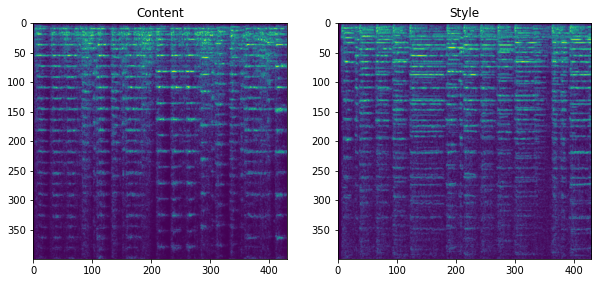

Content


Style


In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.show()

print('Content')
display(Audio(CONTENT_FILENAME))
print('Style')
display(Audio(STYLE_FILENAME))

## Calcoliamo le features

Calcoliamo le features di stile e contenuto. Scegliamo di applicare `4096` filtri di dimensione `(1, 11)` alla convoluzione. Il filtro è generato randomicamente e moltiplicato per una costante $std=11\cdot\sqrt{2\cdot\frac{N\_FREQS}{N\_FILTERS}}$. Portiamo poi in forma di tensore le matrici di contenuto e stile

In [ ]:
N_FILTERS = 4096

std = np.sqrt(2) * np.sqrt(2.0 / ((N_FREQS + N_FILTERS) * 11))
kernel = np.random.randn(1, 11, N_FREQS, N_FILTERS)*std
print('Filter Shape:\t', kernel.shape, '\t(HEIGHT, WIDTH, N_FREQS, N_FILTERS)')

a_content_tf = np.ascontiguousarray(a_content.T[None, None, : , :])
a_style_tf = np.ascontiguousarray(a_style.T[None, None, :, :])
print('Content Shape:\t', a_content_tf.shape, '\t(BATCH, CHANNELS, N_SAMPLES, N_FREQS)')
print('Style Shape:\t', a_style_tf.shape, '\t(BATCH, CHANNELS, N_SAMPLES, N_FREQS)')

Filter Shape:	 (1, 11, 1025, 4096) 	(HEIGHT, WIDTH, N_FREQS, N_FILTERS)
Content Shape:	 (1, 1, 430, 1025) 	(BATCH, CHANNELS, N_SAMPLES, N_FREQS)
Style Shape:	 (1, 1, 430, 1025) 	(BATCH, CHANNELS, N_SAMPLES, N_FREQS)


Creiamo il grafo computazionale di Tensorflow ed una variable `x` che farà da placeholder per l'input. Ovviamente l'input dovrà rispettare la forma del placeholder. La struttura della rete sarà quella di una semplice convoluzione 2D con una ReLU come funzione di attivazione. Una volta ottenute le features, per quelle di stile dobbiamo calcolare la matrice di Gram, ottenuta come prodotto della matrice delle features trasposta per la matrice delle features stesse e poi normalizzata per il numero di samples

In [ ]:
g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.Session() as sess:
    x = tf.placeholder('float32', [1, 1, N_SAMPLES, N_FREQS], name="x")
    
    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    
    conv = tf.nn.conv2d(x, kernel_tf, strides=[1, 1, 1, 1], padding="VALID", name="conv")
    
    net = tf.nn.relu(conv)

    content_features = net.eval(feed_dict={x: a_content_tf})
    style_features = net.eval(feed_dict={x: a_style_tf})
    print('Content Features Shape:\t\t', content_features.shape)
    print('Style Features Shape:\t\t', style_features.shape)
    
    features = np.reshape(style_features, (-1, N_FILTERS))
    print(features.shape)
    style_gram = np.matmul(features.T, features) / N_SAMPLES
    print('Style Features Gram Shape:\t', style_gram.shape)

Content Features Shape:		 (1, 1, 420, 4096)
Style Features Shape:		 (1, 1, 420, 4096)
(420, 4096)
Style Features Gram Shape:	 (4096, 4096)


## Ottimizziamo il modello

Procediamo con l'ottimizzazione calcolando le Loss di contenuto e stile e sfrtuttando la backpropagation per allenare il modello. Utilizziamo un learning rate di partenza di `0.001` e `100` iterazioni. Definiamo anche un coefficiente `ALPHA` da applicare al contenuto e che farà da peso tra le componenti di stile e contenuto nel risultato finale. Procediamo di nuovo col calcolo delle features, questa volta sull'input randomico e passiamo poi a calcolare le loss di stile e contenuto

In [ ]:
from sys import stderr

ALPHA = 1e-2
learning_rate = 1e-3
iterations = 100

result = None
g = tf.Graph()
with g.as_default(), g.device('/gpu:0'):

    x = tf.Variable(np.random.randn(1, 1, N_SAMPLES, N_FREQS).astype(np.float32) * 1e-3, name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')

    conv = tf.nn.conv2d(x, kernel_tf, strides=[1, 1, 1, 1], padding="VALID", name="conv")
    
    net = tf.nn.relu(conv)

    content_loss = ALPHA * 2 * tf.nn.l2_loss(net - content_features)

    feats = tf.reshape(net, (-1, net.get_shape()[3]))
    gram = tf.matmul(tf.transpose(feats), feats)  / N_SAMPLES
    style_loss = 2 * tf.nn.l2_loss(gram - style_gram)

    loss = content_loss + style_loss

    opt = tf.contrib.opt.ScipyOptimizerInterface(loss, method='L-BFGS-B', options={'maxiter': 300})
        
    # Optimization
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
       
        print('Started optimization.')
        opt.minimize(sess)
    
        print('Final loss:', loss.eval())
        result = x.eval()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.global_variables_initializer` instead.


InvalidArgumentError: ignored

## Inversione dello spettrogramma

Invertiamo lo spettrogramma ottenuto e ricostruiamo la fase persa inizialmente per generare lo spettrogramma. Ci avvaliamo dell'algoritmo di Griffin-Lim con `500` iterazioni. Dato che questo algoritmo stima la fase, il nostro output potrà contenere del rumore, anche se con 500 iterazioni riusciamo a limitarlo tanto da renderlo trascurabile

In [ ]:
a = np.zeros_like(a_content)
a[:N_FREQS,:] = np.exp(result[0,0].T) - 1

x = librosa.griffinlim(a, 500)

sf.write(OUTPUT_FILENAME, x, fs)

## Risultato

Confrontiamo gli spettrogrammi e ascoltiamo il risultato

In [ ]:
def est_bpm(filename):
  src, sr = librosa.load(filename)
  return round(librosa.beat.tempo(src, sr)[0])

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1,3,2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.subplot(1,3,3)
plt.title('Result')
plt.imshow(a[:400,:])
plt.show()

print("Content,", "BPM:", est_bpm(CONTENT_FILENAME))
display(Audio(CONTENT_FILENAME))
print("Style,", "BPM:", est_bpm(STYLE_FILENAME))
display(Audio(STYLE_FILENAME))
print("Output,", "BPM:", est_bpm(OUTPUT_FILENAME))
display(Audio(OUTPUT_FILENAME))

## Esempi

Vediamo altri esempi già calcolati dal modello

In [ ]:
CONTENT = "inputs/imperial.mp3"
STYLE = "inputs/usa.mp3"
OUTPUT = "tf_outputs/imperial_usa.wav"
print("Content,", "BPM:", est_bpm(CONTENT))
display(Audio(CONTENT))
print("Style,", "BPM:", est_bpm(STYLE))
display(Audio(STYLE))
print("Output,", "BPM:", est_bpm(OUTPUT))
display(Audio(OUTPUT))

In [ ]:
CONTENT = "inputs/imperial.mp3"
STYLE = "inputs/russia.mp3"
OUTPUT = "tf_outputs/imperial_russia.wav"
print("Content,", "BPM:", est_bpm(CONTENT))
display(Audio(CONTENT))
print("Style,", "BPM:", est_bpm(STYLE))
display(Audio(STYLE))
print("Output,", "BPM:", est_bpm(OUTPUT))
display(Audio(OUTPUT))

In [ ]:
CONTENT = "inputs/eminem.mp3"
STYLE = "inputs/futurama.mp3"
OUTPUT = "tf_outputs/eminem_futurama.wav"
print("Content,", "BPM:", est_bpm(CONTENT))
display(Audio(CONTENT))
print("Style,", "BPM:", est_bpm(STYLE))
display(Audio(STYLE))
print("Output,", "BPM:", est_bpm(OUTPUT))
display(Audio(OUTPUT))

Facendo un resoconto notiamo come certe tracce si legano maggiormente rispetto ad altre che invece producono loss abbastanza elevate. In particolare sembrerebbe che le tracce con BPM fortmente discostanti facciano più fatica a legare, come nel caso *imperial-russia*. Nel caso *eminem-futurama* invece, nonostante i BPM siano simili, c'è un evidente discostamento generale tra le tracce che rende quindi la loss molto alta

<table>
  <th>Content</th>
  <th>Style</th>
  <th>Content BPM</th>
  <th>Style BPM</th>
  <th>Loss</th>
  <tr>
    <td>imperial</td>
    <td>usa</td>
    <td>103</td>
    <td>89</td>
    <td>~ 600</td>
  </tr>
  <tr>
    <td>imperial</td>
    <td>russia</td>
    <td>103</td>
    <td>129</td>
    <td>~ 800</td>
  </tr>
  <tr>
    <td>eminem</td>
    <td>futurama</td>
    <td>112</td>
    <td>117</td>
    <td>~ 2000</td>
  </tr>
  
</table>